# Description

This code loads in raw HadCRUT5 global mean temperature data, analyzes it, and saves out an analysis netcdf file, [GMST-3yrmean.nc](./data/analysis/GMST-3yrmean.nc), of 3-year running mean observed global mean temperature anomalies since the IPCC reference period (1850&mdash;1899).

We plot these temperatures and (and their anomalies over the time periods of interest in this study) along with the uncertainty envelope of the CMIP5 GMST anomalies over the period, creating and saving out Fig. S1.

**FIGURES PRODUCED IN THIS CODE**
* [Fig. S1](./paper_figures/si/figS1.pdf)

# Setup

In [1]:
# import the packages we need to run this code
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utilities as util

# define the locations to save the figures into
fig_main_savepath='./paper_figures/main/'
fig_si_savepath='./paper_figures/si/'

# Load HadCRUT5 Data

Data originally downloaded by Daniel Gilford from the [Met Office Hadley Centre observations datasets](https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html) on 17 August 2021.

In [2]:
# setup variables to load and organize the data
datpath='./data/hadcrut/'
gmst_metric='tas_mean'
hadpath=datpath+'HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.nc'
# load the data into a data structure
haddat = xr.open_dataset(hadpath)

## Look at HadCRUT5 GMST metadata

In [3]:
haddat

<xarray.Dataset>
Dimensions:           (time: 2058, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2021-06-16
    latitude          float64 ...
    longitude         float64 ...
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (bnds) float64 ...
    longitude_bnds    (bnds) float64 ...
    realization_bnds  (bnds) int64 ...
    tas_lower         (time) float64 ...
    tas_upper         (time) float64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

### Load CMIP5 Data for Plotting

To include a comparison with the climate models, we load in data created with [CMIP5_GMST.ipynb](./CMIP5_GMST.ipynb). The CMIP5 GMST anomalies share the same reference period and 3-year rolling mean qualities.

In [4]:
# Load in the saved out 3-year rolling average GMST data
cmip5_loadpath='./data/analysis/CMIP5-GMST-3yrmean.nc'
cmip5_ds=xr.open_dataset(cmip5_loadpath)
# get the model variable names, for posterity
model_names=[key for key in cmip5_ds.keys()]

#### Calculate the CMIP5 model GMST envelope

We will calculate the 1$\sigma$ GMSTs (assuming a normal distribution of the model timeseries outcomes in each year) by evaluating the 17th and 83rd percentiles of the model GMST anomaly timeseries.

In [5]:
# push into a single array
cmip5_3year_array=cmip5_ds.to_array()
# calculate the 18th-83rd percentiles for the CMIP5 models
ql,qu=0.17,0.83
qlluu=[ql,qu]
gmst_qq=cmip5_ds.to_array().quantile(qlluu,dim='variable')

/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


# Organize Data

In [6]:
# get the global mean
GMST=haddat[gmst_metric]

### Define time periods of interest
i.e.
* IPCC Reference period: 1850&mdash;1899
* 31-year Counterfactual period: 1885&mdash;1915
* Climatology period: 1985&mdash;2015
* IPCC Modern Warming period (since Reference): 2010&mdash;2019

In [7]:
# get the slices

# IPCC reference period
refperiod=np.asarray([1850,1899])
ref_slice=util.dt64_yrslice(refperiod[0],refperiod[1])

# Counterfactual
cf_period=np.asarray([1885,1915])
cf_slice=util.dt64_yrslice(cf_period[0],cf_period[1])

# 31-year reliably-observed climatology
climperiod=np.asarray([1985,2015])
clim_slice=util.dt64_yrslice(climperiod[0],climperiod[1])

# Decade of modern warming relative to the IPCC reference period
ipccwarmperiod=np.asarray([2010,2019])
ipcc_warm_slice=util.dt64_yrslice(ipccwarmperiod[0],ipccwarmperiod[1])

In [8]:
# take the slices
refdat=GMST.sel(time=ref_slice)
cf_dat=GMST.sel(time=cf_slice)
climdat=GMST.sel(time=clim_slice)
ipcc_warm_dat=GMST.sel(time=ipcc_warm_slice)

### Calculate differences between time periods of interest

In [9]:
# calculate the differences between periods
delta_cf=np.round((cf_dat.mean()-refdat.mean()).values,2)
delta_clim=np.round((climdat.mean()-refdat.mean()).values,2)
delta_ipcc=np.round((ipcc_warm_dat.mean()-refdat.mean()).values,2)
print('{0:+}'.format(delta_ipcc)+'C temperature change since 1850-1900')

+1.09C temperature change since 1850-1900


Note that the attributable warming (from IPCC) is 1.07C, while the IPCC observed warming (2010-2019 relative to the reference period of 1850-1899) is 1.09C.

In [10]:
# define the attributable warming from the IPCC, for reference
delta_107C=np.round(1.07,2)

# Analyze

### Change timeseries reference period

In [11]:
# find the anomaly timeseries relative to the reference period
GMST_anomaly=GMST-refdat.mean()

### Smooth internal variability on full timeseries

In [12]:
# take the 3-year mean (36 months)
smooth_months=36
# use a boxcar filter and center the output
had3yrmean=GMST_anomaly.rolling(time=smooth_months,center=True).mean()

## Plot the timeseries and slices, for reference

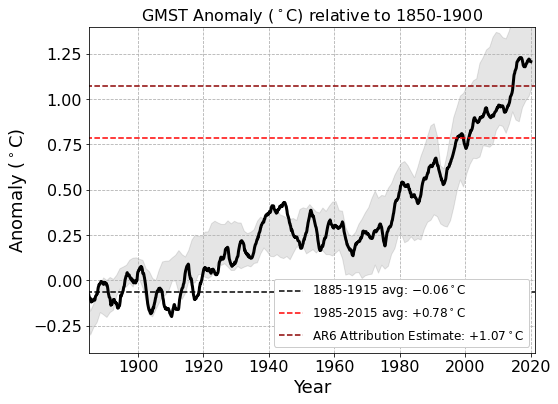

In [13]:
fig=plt.figure(figsize=(8,6))
# plot the HadCRUT timeseries
plt.plot(had3yrmean.time,had3yrmean, \
         lw=3,color='k',label=None)
plt.hlines(cf_dat.mean()-refdat.mean(),had3yrmean.time.min().values,had3yrmean.time.max().values, \
           color='k',linestyle='--',label='1885-1915 avg: $'+str(delta_cf)+'^\circ$C')
plt.hlines(climdat.mean()-refdat.mean(),had3yrmean.time.min().values,had3yrmean.time.max().values, \
           color='r',linestyle='--',label='1985-2015 avg: $+'+str(delta_clim)+'^\circ$C')
plt.hlines(delta_107C,had3yrmean.time.min().values,had3yrmean.time.max().values, \
           color='darkred',linestyle='--',label='AR6 Attribution Estimate: $+1.07^\circ$C')

# add in the CMIP5 timeseries envelope
plt.fill_between(gmst_qq[0,::1].time.values,gmst_qq[0,::1],gmst_qq[1,::1], \
                 color='k',alpha=0.1)

plt.xlim(had3yrmean.time.sel(time=util.dt64_yrslice(cf_period[0],2021))[0].values,had3yrmean.time.sel(time=util.dt64_yrslice(cf_period[0],2021))[-1].values)
plt.ylim([-0.4,1.4])
plt.grid(linestyle='--')
plt.title('GMST Anomaly ($^\circ$C) relative to 1850-1900',fontsize=16)
plt.xlabel('Year',fontsize=18)
plt.ylabel('Anomaly ($^\circ$C)',fontsize=18)
plt.yticks(np.arange(-0.25,1.25+1e-10,0.25),fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=12,loc='lower right',framealpha=1.0)
plt.show()

# save the plot out
plot_save_name='figS1.pdf'
fig.savefig(fig_si_savepath+plot_save_name, dpi=300, bbox_inches='tight')


# Save out Data

In [14]:
# define the savepath and name
datsavepath='./data/analysis/GMST-3yrmean.nc'

In [15]:
del GMST
# organize to save out
GMST=had3yrmean.drop(['realization','latitude','longitude']).rename('GMST-3yrmean')
GMST.attrs['description']='3-year centered boxcar mean of HadCRUT5 global mean near surface temperature anomalies (C) relative to 1850-1899'
GMST.attrs['unit']='Celsius'
GMST.attrs['IPCC_reference_period']='1850-1899'
GMST.attrs['download_date']='08-17-2021'
GMST.attrs['download_from']='https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html'
GMST.attrs['download_version']='HadCRUT.5.0.1.0'

# store the anomalies
GMST['Counterfactual_Delta']=(cf_dat.mean()-refdat.mean()).values
GMST['Counterfactual_Period']='1885-1915'
GMST['CLIM_Delta']=(climdat.mean()-refdat.mean()).values
GMST['CLIM_Period']='1985-2015'
GMST['Attributable_Delta']=delta_107C

# print what we are about to save
print(GMST)

GMST.to_netcdf(datsavepath)

<xarray.DataArray 'GMST-3yrmean' (time: 2058)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time                   (time) datetime64[ns] 1850-01-16T12:00:00 ... 2021...
    Counterfactual_Delta   float64 -0.06344
    Counterfactual_Period  <U9 '1885-1915'
    CLIM_Delta             float64 0.784
    CLIM_Period            <U9 '1985-2015'
    Attributable_Delta     float64 1.07
Attributes:
    description:            3-year centered boxcar mean of HadCRUT5 global me...
    unit:                   Celsius
    IPCC_reference_period:  1850-1899
    download_date:          08-17-2021
    download_from:          https://www.metoffice.gov.uk/hadobs/hadcrut5/data...
    download_version:       HadCRUT.5.0.1.0
